# AI Explanations: Deploying an Explainable Image Model with Vertex AI 

## Overview

This lab shows how to train a classification model on image data and deploy it to Vertex AI to serve predictions with explanations (feature attributions). In this lab you will:
* Explore the dataset
* Build and train a custom image classification model with Vertex AI
* Deploy the model to an endpoint
* Serve predictions with Explanations
* Visualize feature attributions from Integrated Gradients

In [ ]:
# Install needed deps
!pip install opencv-python

## Setup

In [1]:
import os

shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT_ID = shell_output[0]
REGION = "us-central1"
print("Project ID:", PROJECT_ID)

Project ID: kylesteckler-demo


In [2]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
REGION = "us-central1"
GCS_PATTERN = "gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec"
DATA_PATH = f"gs://{BUCKET}/flowers/data"
OUTDIR = f"gs://{BUCKET}/flowers/model_{TIMESTAMP}"

os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["DATA_PATH"] = DATA_PATH
os.environ["OUTDIR"] = OUTDIR
os.environ["TIMESTAMP"] = TIMESTAMP

Run the following cell to create your Cloud Storage bucket if it does not already exist.

In [3]:
%%bash
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
   echo -e "Bucket gs://${BUCKET} already exists."
    
else
   echo "Creating a new GCS bucket."
   gsutil mb -l ${REGION} gs://${BUCKET}
   echo -e "\nHere are your current buckets:"
   gsutil ls
fi

Bucket gs://kylesteckler-demo already exists.


### Import libraries

Import the libraries for this tutorial.

In [4]:
import base64
import random

import cv2
import google.cloud.aiplatform as aip
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

## Explore the Dataset
The dataset used for this tutorial is the [flowers dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). This section shows how to shuffle, split and copy the files to your GCS bucket. 

### Load, split, and copy the dataset to your GCS bucket

In [5]:
TRAINING_DATA_PATH = DATA_PATH + "/training"
EVAL_DATA_PATH = DATA_PATH + "/validation"

IMAGE_SIZE = [192, 192]
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# Split data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
random.shuffle(filenames)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]

# Copy training files to GCS
for file in training_filenames:
    !gsutil -m cp $file $TRAINING_DATA_PATH/

# Copy eval files to GCS
for file in validation_filenames:
    !gsutil -m cp $file $EVAL_DATA_PATH/

Copying gs://flowers-public/tfrecords-jpeg-192x192-2/flowers00-230.tfrec...
/ [1/1 files][  6.0 MiB/  6.0 MiB] 100% Done                                    
Operation completed over 1 objects/6.0 MiB.                                      
Copying gs://flowers-public/tfrecords-jpeg-192x192-2/flowers10-230.tfrec...
- [1/1 files][  5.6 MiB/  5.6 MiB] 100% Done                                    
Operation completed over 1 objects/5.6 MiB.                                      
Copying gs://flowers-public/tfrecords-jpeg-192x192-2/flowers12-230.tfrec...
/ [1/1 files][  6.0 MiB/  6.0 MiB] 100% Done                                    
Operation completed over 1 objects/6.0 MiB.                                      
Copying gs://flowers-public/tfrecords-jpeg-192x192-2/flowers11-230.tfrec...
/ [1/1 files][  5.8 MiB/  5.8 MiB] 100% Done                                    
Operation completed over 1 objects/5.8 MiB.                                      
Copying gs://flowers-public/tfrecords-jpeg-1

Run the following commands. You should see a number of .tfrec files in your GCS bucket under both gs://{BUCKET}/flowers/data/training and gs://{BUCKET}/flowers/data/validation

In [6]:
!gsutil ls -l $TRAINING_DATA_PATH

   6250983  2022-03-04T16:39:06Z  gs://kylesteckler-demo/flowers/data/training/flowers00-230.tfrec
   6231074  2022-03-04T16:39:22Z  gs://kylesteckler-demo/flowers/data/training/flowers01-230.tfrec
   5952336  2022-03-04T16:39:18Z  gs://kylesteckler-demo/flowers/data/training/flowers02-230.tfrec
   6254378  2022-03-04T16:39:14Z  gs://kylesteckler-demo/flowers/data/training/flowers03-230.tfrec
   6100076  2022-03-04T16:39:24Z  gs://kylesteckler-demo/flowers/data/training/flowers05-230.tfrec
   5968916  2022-03-04T16:36:37Z  gs://kylesteckler-demo/flowers/data/training/flowers06-230.tfrec
   6088244  2022-03-04T16:39:16Z  gs://kylesteckler-demo/flowers/data/training/flowers07-230.tfrec
   6162742  2022-03-04T16:36:39Z  gs://kylesteckler-demo/flowers/data/training/flowers08-230.tfrec
   6346261  2022-03-04T16:39:28Z  gs://kylesteckler-demo/flowers/data/training/flowers09-230.tfrec
   5917130  2022-03-04T16:39:08Z  gs://kylesteckler-demo/flowers/data/training/flowers10-230.tfrec
   6105472

In [7]:
!gsutil ls -l $EVAL_DATA_PATH

   6231074  2022-03-04T16:36:53Z  gs://kylesteckler-demo/flowers/data/validation/flowers01-230.tfrec
   6056727  2022-03-04T16:39:32Z  gs://kylesteckler-demo/flowers/data/validation/flowers04-230.tfrec
   5968916  2022-03-04T16:39:34Z  gs://kylesteckler-demo/flowers/data/validation/flowers06-230.tfrec
   6088244  2022-03-04T16:36:49Z  gs://kylesteckler-demo/flowers/data/validation/flowers07-230.tfrec
   6162742  2022-03-04T16:39:36Z  gs://kylesteckler-demo/flowers/data/validation/flowers08-230.tfrec
TOTAL: 5 objects, 30507703 bytes (29.09 MiB)


### Create ingest functions and visualize some of the examples
Define and execute helper functions to plot the images and corresponding labels.

2022-03-04 16:39:39.571604: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-03-04 16:39:39.715307: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


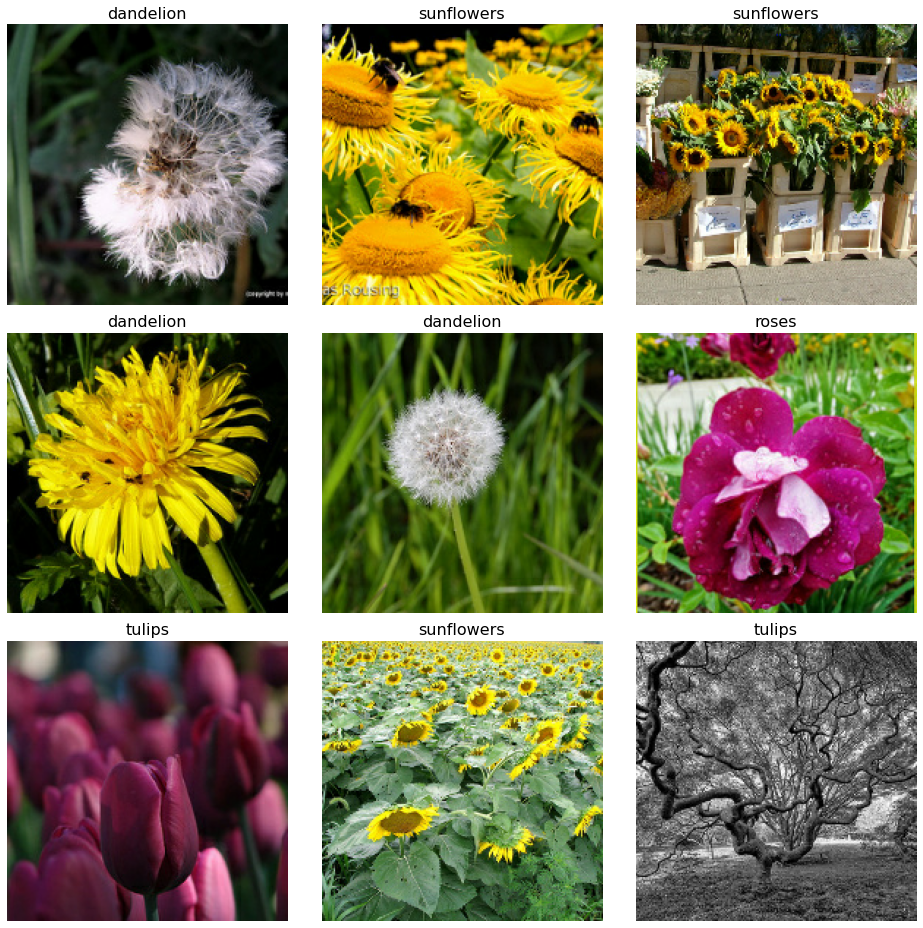

In [8]:
# Do not change, maps to the labels in the data
CLASSES = [
    "daisy",
    "dandelion",
    "roses",
    "sunflowers",
    "tulips",
]


def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature(
            [], tf.string
        ),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = (
        tf.cast(image, tf.float32) / 255.0
    )  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    one_hot_class = tf.sparse.to_dense(example["one_hot_class"])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class


def load_dataset(gcs_pattern):
    filenames = filenames = tf.io.gfile.glob(gcs_pattern + "/*")
    ds = tf.data.TFRecordDataset(filenames).map(read_tfrecord)
    return ds


def dataset_to_numpy(dataset, N):
    numpy_images = []
    numpy_labels = []

    for images, labels in dataset.take(N):
        numpy_images.append(images.numpy())
        numpy_labels.append(labels.numpy())

    return numpy_images, numpy_labels


def display_one_image(image, title, subplot):
    plt.subplot(subplot)
    plt.axis("off")
    plt.imshow(image)
    plt.title(title, fontsize=16)
    return subplot + 1


def display_9_images_from_dataset(dataset):
    subplot = 331
    plt.figure(figsize=(13, 13))
    images, labels = dataset_to_numpy(dataset, 9)
    for i, image in enumerate(images):
        title = CLASSES[np.argmax(labels[i], axis=-1)]
        subplot = display_one_image(image, title, subplot)
        if i >= 8:
            break

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


# Display 9 examples from the dataset
ds = load_dataset(gcs_pattern=TRAINING_DATA_PATH)
display_9_images_from_dataset(ds)

## Build training pipeline
In this section you will build an application with keras to train an image classification model on Vertex AI Custom Training. 

Create a directory for the training application and an __ init __.py file (this is required for a Python application but it can be empty).

In [9]:
%%bash 
mkdir -p flowers/trainer
touch flowers/trainer/__init__.py

### Create task.py
Create trainer module's task.py to hold hyperparameter argparsing code.

The cell below writes the file `flowers/trainer/task.py` which sets up our training job. Here is where we determine which parameters of our model to pass as flags during training using the `parser` module. Be sure to include a default value for the parsed arguments above and specfy the `type` if necessary.

In [10]:
%%writefile flowers/trainer/task.py

import argparse
import json
import os

from trainer import model

import tensorflow as tf

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--train_data_path",
        help="GCS location of training data",
        required=True
    )
    parser.add_argument(
        "--eval_data_path",
        help="GCS location of evaluation data",
        required=True
    )
    parser.add_argument(
        "--output_dir",
        help="GCS location to write checkpoints and export models",
        default = os.getenv("AIP_MODEL_DIR")
    )
    parser.add_argument(
        "--batch_size",
        help="Number of examples to compute gradient over.",
        type=int,
        default=32
    )
    parser.add_argument(
        "--num_epochs",
        help="Number of epochs to train for.",
        type=int,
        default=20
    )
    parser.add_argument(
        "--train_examples",
        help="Number of examples to run the training job over.",
        type=int,
        default=100
    )

    # Parse all arguments
    args = parser.parse_args()
    arguments = args.__dict__

    # Run the training job
    model.train_and_evaluate(arguments)


Writing flowers/trainer/task.py


### Create trainer module's model.py to hold Keras model code.
This code will contain the training logic. Here we will build an application to ingest data from GCS and train a CNN model built with tf.keras.

In [11]:
%%writefile flowers/trainer/model.py

import tensorflow as tf 
import datetime
import os 

IMAGE_SIZE = [192,192]

# Using the same read_tfrecord function
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature(
            [], tf.string
        ),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = (
        tf.cast(image, tf.float32) / 255.0
    )  # convert image to floats in [0, 1] range
    image = tf.reshape(
        image, [*IMAGE_SIZE, 3]
    )  
    one_hot_class = tf.sparse.to_dense(example["one_hot_class"])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class

def load_dataset(gcs_pattern, batch_size=32, training=True):
    filenames = filenames = tf.io.gfile.glob(gcs_pattern)
    ds = tf.data.TFRecordDataset(filenames).map(read_tfrecord).batch(batch_size)
    if training:
        return ds.repeat()
    else:
        return ds 
    
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(
            kernel_size=3,filters=16, padding="same", activation="relu",input_shape=[*IMAGE_SIZE, 3]
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(
            kernel_size=3, filters=32, padding="same", activation="relu"
        ),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(
            kernel_size=3, filters=64, padding="same", activation="relu"
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.Conv2D(
            kernel_size=3, filters=96, padding="same", activation="relu"
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(
            kernel_size=1, filters=32, padding="same", activation="relu"
        ),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(5, activation="softmax")
    ])
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def train_and_evaluate(args):
    model = build_model()
    train_ds = load_dataset(gcs_pattern=args['train_data_path'], batch_size=args['batch_size'])
    eval_ds = load_dataset(gcs_pattern=args['eval_data_path'], training=False)
    num_batches = args["batch_size"] * args["num_epochs"]
    steps_per_epoch = args["train_examples"] // num_batches
    
    history = model.fit(
        train_ds,
        validation_data=eval_ds,
        epochs=args["num_epochs"],
        steps_per_epoch=steps_per_epoch,
        verbose=2,  # 0=silent, 1=progress bar, 2=one line per epoch
    )

    tf.saved_model.save(
        obj=model, export_dir=args['output_dir']
    )  # with default serving function
    
    print("Exported trained model to {}".format(args['output_dir']))
    


Writing flowers/trainer/model.py


### Test training application locally 
It's always a good idea to test out a training application locally (with only a few training steps) to make sure the code runs as expected.

In [12]:
%%bash
OUTDIR_LOCAL=local_test_training
rm -rf ${OUTDIR_LOCAL}
export PYTHONPATH=${PYTHONPATH}:${PWD}/flowers
python3 -m trainer.task \
    --train_data_path=gs://${BUCKET}/flowers/data/training/*.tfrec\
    --eval_data_path=gs://${BUCKET}/flowers/data/validation/*.tfrec \
    --output_dir=${OUTDIR_LOCAL} \
    --batch_size=1 \
    --num_epochs=1 \
    --train_examples=10 

10/10 - 15s - loss: 1.7919 - accuracy: 0.1000 - val_loss: 1.6046 - val_accuracy: 0.2713
Exported trained model to local_test_training


2022-03-04 16:39:43.403624: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-03-04 16:39:44.058708: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-04 16:40:06.360756: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Package code as source distribution
Now that you have validated your model training code, we need to package our code as a source distribution in order to submit a custom training job to Vertex AI.

In [13]:
%%writefile flowers/setup.py
from setuptools import find_packages
from setuptools import setup

setup(
    name='flowers_trainer',
    version='0.1',
    packages=find_packages(),
    include_package_data=True,
    description='Flowers image classifier training application.'
)

Writing flowers/setup.py


In [14]:
%%bash
cd flowers
python ./setup.py sdist --formats=gztar
cd ..

running sdist
running egg_info
creating flowers_trainer.egg-info
writing flowers_trainer.egg-info/PKG-INFO
writing dependency_links to flowers_trainer.egg-info/dependency_links.txt
writing top-level names to flowers_trainer.egg-info/top_level.txt
writing manifest file 'flowers_trainer.egg-info/SOURCES.txt'
reading manifest file 'flowers_trainer.egg-info/SOURCES.txt'
writing manifest file 'flowers_trainer.egg-info/SOURCES.txt'
running check
creating flowers_trainer-0.1
creating flowers_trainer-0.1/flowers_trainer.egg-info
creating flowers_trainer-0.1/trainer
copying files to flowers_trainer-0.1...
copying setup.py -> flowers_trainer-0.1
copying flowers_trainer.egg-info/PKG-INFO -> flowers_trainer-0.1/flowers_trainer.egg-info
copying flowers_trainer.egg-info/SOURCES.txt -> flowers_trainer-0.1/flowers_trainer.egg-info
copying flowers_trainer.egg-info/dependency_links.txt -> flowers_trainer-0.1/flowers_trainer.egg-info
copying flowers_trainer.egg-info/top_level.txt -> flowers_trainer-0.1/f

Store the package in GCS

In [15]:
%%bash
gsutil cp flowers/dist/flowers_trainer-0.1.tar.gz gs://${BUCKET}/flowers/

Copying file://flowers/dist/flowers_trainer-0.1.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  2.1 KiB/  2.1 KiB]                                                
Operation completed over 1 objects/2.1 KiB.                                      


To submit to the Cloud we use [`gcloud custom-jobs create`](https://cloud.google.com/sdk/gcloud/reference/ai/custom-jobs/create) and simply specify some additional parameters for the Vertex AI Training Service:
- display-name: A unique identifier for the Cloud job. We usually append system time to ensure uniqueness
- region: Cloud region to train in. See [here](https://cloud.google.com/vertex-ai/docs/general/locations) for supported Vertex AI Training Service regions

You might have earlier seen `gcloud ai custom-jobs create` executed with the `worker pool spec` and pass-through Python arguments specified directly in the command call, here we will use a YAML file, this will make it easier to transition to hyperparameter tuning.

Through the `args:` argument we add in the passed-through arguments for our `task.py` file.

In [16]:
%%bash
JOB_NAME=flowers_${TIMESTAMP}

PYTHON_PACKAGE_URI=gs://${BUCKET}/flowers/flowers_trainer-0.1.tar.gz
PYTHON_PACKAGE_EXECUTOR_IMAGE_URI="us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-3:latest"
PYTHON_MODULE=trainer.task

echo > ./config.yaml "workerPoolSpecs:
  machineSpec:
    machineType: n1-standard-8
  replicaCount: 1
  pythonPackageSpec:
    executorImageUri: $PYTHON_PACKAGE_EXECUTOR_IMAGE_URI
    packageUris: $PYTHON_PACKAGE_URI
    pythonModule: $PYTHON_MODULE
    args:
    - --train_data_path=gs://${BUCKET}/flowers/data/training/*.tfrec
    - --eval_data_path=gs://${BUCKET}/flowers/data/validation/*.tfrec
    - --output_dir=$OUTDIR
    - --num_epochs=30
    - --train_examples=10000
    - --batch_size=16
    "

gcloud ai custom-jobs create \
  --region=${REGION} \
  --display-name=$JOB_NAME \
  --config=config.yaml

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
CustomJob [projects/693210680039/locations/us-central1/customJobs/8934947047144947712] is submitted successfully.

Your job is still active. You may view the status of your job with the command

  $ gcloud ai custom-jobs describe projects/693210680039/locations/us-central1/customJobs/8934947047144947712

or continue streaming the logs with the command

  $ gcloud ai custom-jobs stream-logs projects/693210680039/locations/us-central1/customJobs/8934947047144947712


**NOTE** Model training will take 15-25 minutes. You have to wait for training to finish before moving forward.

### Serving function for image data

To pass images to the prediction service, you encode the compressed (e.g., JPEG) image bytes into base 64 -- which makes the content safe from modification while transmitting binary data over the network. Since this deployed model expects input data as raw (uncompressed) bytes, you need to ensure that the base 64 encoded data gets converted back to raw bytes before it is passed as input to the deployed model.

To resolve this, define a serving function (`serving_fn`) and attach it to the model as a preprocessing step. Add a `@tf.function` decorator so the serving function is fused to the underlying model (instead of upstream on a CPU).

When you send a prediction or explanation request, the content of the request is base 64 decoded into a Tensorflow string (`tf.string`), which is passed to the serving function (`serving_fn`). The serving function preprocesses the `tf.string` into raw (uncompressed) numpy bytes (`preprocess_fn`) to match the input requirements of the model:
- `io.decode_jpeg`- Decompresses the JPG image which is returned as a Tensorflow tensor with three channels (RGB).
- `image.convert_image_dtype` - Changes integer pixel values to float 32.
- `image.resize` - Resizes the image to match the input shape for the model.
- `resized / 255.0` - Rescales (normalization) the pixel data between 0 and 1.

At this point, the data can be passed to the model (`m_call`).

#### XAI Signatures

When the serving function is saved back with the underlying model (`tf.saved_model.save`), you specify the input layer of the serving function as the signature `serving_default`.

For XAI image models, you need to save two additional signatures from the serving function:

- `xai_preprocess`: The preprocessing function in the serving function.
- `xai_model`: The concrete function for calling the model.

Load the model into memory. **NOTE** This directory will not exist if your model has not finished training. Please wait for training to complete before moving forward

In [18]:
local_model = tf.keras.models.load_model(OUTDIR)

In [19]:
CONCRETE_INPUT = "numpy_inputs"


def _preprocess(bytes_input):
    decoded = tf.io.decode_jpeg(bytes_input, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    resized = tf.image.resize(decoded, size=(192, 192))
    rescale = tf.cast(resized / 255.0, tf.float32)
    return rescale


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(bytes_inputs):
    decoded_images = tf.map_fn(
        _preprocess, bytes_inputs, dtype=tf.float32, back_prop=False
    )
    return {
        CONCRETE_INPUT: decoded_images
    }  # User needs to make sure the key matches model's input


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def serving_fn(bytes_inputs):
    images = preprocess_fn(bytes_inputs)
    prob = m_call(**images)
    return prob


m_call = tf.function(local_model.call).get_concrete_function(
    [
        tf.TensorSpec(
            shape=[None, 192, 192, 3], dtype=tf.float32, name=CONCRETE_INPUT
        )
    ]
)

tf.saved_model.save(
    local_model,
    OUTDIR,
    signatures={
        "serving_default": serving_fn,
        # Required for XAI
        "xai_preprocess": preprocess_fn,
        "xai_model": m_call,
    },
)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
Use fn_output_signature instead


2022-03-04 17:22:14.269120: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://kylesteckler-demo/flowers/model_20220304163900/assets
INFO:tensorflow:Assets written to: gs://kylesteckler-demo/flowers/model_20220304163900/assets


## Get the serving function signature

You can get the signatures of your model's input and output layers by reloading the model into memory, and querying it for the signatures corresponding to each layer.

When making a prediction request, you need to route the request to the serving function instead of the model, so you need to know the input layer name of the serving function -- which you will use later when you make a prediction request.

You also need to know the name of the serving function's input and output layer for constructing the explanation metadata -- which is discussed subsequently.

In [20]:
loaded = tf.saved_model.load(OUTDIR)

serving_input = list(
    loaded.signatures["serving_default"].structured_input_signature[1].keys()
)[0]
print("Serving function input:", serving_input)
serving_output = list(
    loaded.signatures["serving_default"].structured_outputs.keys()
)[0]
print("Serving function output:", serving_output)

input_name = local_model.input.name
print("Model input name:", input_name)
output_name = local_model.output.name
print("Model output name:", output_name)

Serving function input: bytes_inputs
Serving function output: output_0
Model input name: conv2d_input
Model output name: dense/Softmax:0


In [21]:
parameters = aip.explain.ExplanationParameters(
    {"integrated_gradients_attribution": {"step_count": 50}}
)

## Upload the model

Next, upload your model to a `Model` resource using `Model.upload()` method, with the following parameters:

- `display_name`: The human readable name for the `Model` resource.
- `artifact`: The Cloud Storage location of the trained model artifacts.
- `serving_container_image_uri`: The serving container image.
- `sync`: Whether to execute the upload asynchronously or synchronously.
- `explanation_parameters`: Parameters to configure explaining for `Model`'s predictions.
- `explanation_metadata`: Metadata describing the `Model`'s input and output for explanation.

If the `upload()` method is run asynchronously, you can subsequently block until completion with the `wait()` method.

**NOTE** This can take a few minutes to run. 

In [22]:
MODEL_NAME = "flower_classifier"
INPUT_METADATA = {"input_tensor_name": CONCRETE_INPUT, "modality": "image"}
OUTPUT_METADATA = {"output_tensor_name": serving_output}

input_metadata = aip.explain.ExplanationMetadata.InputMetadata(INPUT_METADATA)
output_metadata = aip.explain.ExplanationMetadata.OutputMetadata(
    OUTPUT_METADATA
)

metadata = aip.explain.ExplanationMetadata(
    inputs={"image": input_metadata}, outputs={"class": output_metadata}
)

In [23]:
aip.init(project=PROJECT_ID, staging_bucket=BUCKET)
model = aip.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=OUTDIR,
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest",
    explanation_parameters=parameters,
    explanation_metadata=metadata,
    sync=False,
)

model.wait()

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/693210680039/locations/us-central1/models/2837799928871256064/operations/4599182990671609856
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/693210680039/locations/us-central1/models/2837799928871256064
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/693210680039/locations/us-central1/models/2837799928871256064')


## Deploy the model

Next, deploy your model for online prediction. To deploy the model, you invoke the `deploy` method, with the following parameters:

- `deployed_model_display_name`: A human readable name for the deployed model.
- `traffic_split`: Percent of traffic at the endpoint that goes to this model, which is specified as a dictionary of one or more key/value pairs.
If only one model, then specify as { "0": 100 }, where "0" refers to this model being uploaded and 100 means 100% of the traffic.
If there are existing models on the endpoint, for which the traffic will be split, then use model_id to specify as { "0": percent, model_id: percent, ... }, where model_id is the model id of an existing model to the deployed endpoint. The percents must add up to 100.
- `machine_type`: The type of machine to use for training.
- `max_replica_count`: The maximum number of compute instances to scale to. In this tutorial, only one instance is provisioned.

**NOTE** This can take a few minutes.  

In [26]:
endpoint = model.deploy(
    deployed_model_display_name=MODEL_NAME,
    traffic_split={"0": 100},
    machine_type="n1-standard-4",
    min_replica_count=1,
    max_replica_count=1,
)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/693210680039/locations/us-central1/endpoints/354420976143826944/operations/7425191756846596096
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/693210680039/locations/us-central1/endpoints/354420976143826944
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/693210680039/locations/us-central1/endpoints/354420976143826944')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/693210680039/locations/us-central1/endpoints/354420976143826944
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/693210680039/locations/us-central1/endpoints/354420976143826944/operations/8704214051019816960
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/693210680039/loc

### Prepare the request content
You are going to send the flower image as compressed JPG image, instead of the raw uncompressed bytes:

- `cv2.imwrite`: Use openCV to write the uncompressed image to disk as a compressed JPEG image.
 - Denormalize the image data from \[0,1) range back to [0,255).
 - Convert the 32-bit floating point values to 8-bit unsigned integers.
- `tf.io.read_file`: Read the compressed JPG images back into memory as raw bytes.
- `base64.b64encode`: Encode the raw bytes into a base 64 encoded string.

In [27]:
eval_ds = load_dataset(EVAL_DATA_PATH)
x_test, y_test = dataset_to_numpy(eval_ds, 5)

# Single image from eval dataset
test_image = x_test[0] * 255.0

cv2.imwrite("tmp.jpg", test_image)

True

In [28]:
bytes = tf.io.read_file("tmp.jpg")
b64str = base64.b64encode(bytes.numpy()).decode("utf-8")

instances_list = [{serving_input: {"b64": b64str}}]

response = endpoint.explain(instances_list)
print(response)

Prediction(predictions=[[0.165272191, 0.808939219, 0.0212947931, 0.000694787479, 0.00379896793]], deployed_model_id='6595618411307335680', explanations=[attributions {
  baseline_output_value: 0.8092078566551208
  instance_output_value: 0.8089390993118286
  feature_attributions {
    struct_value {
      fields {
        key: "image"
        value {
          struct_value {
            fields {
              key: "b64_jpeg"
              value {
                string_value: "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCADAAMADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb

### Visualize feature attributions from Integrated Gradients. 
Query the response to get predictions and feature attributions. Use Matplotlib to visualize.

Predicted class: dandelion
Confidence score: 0.808939219


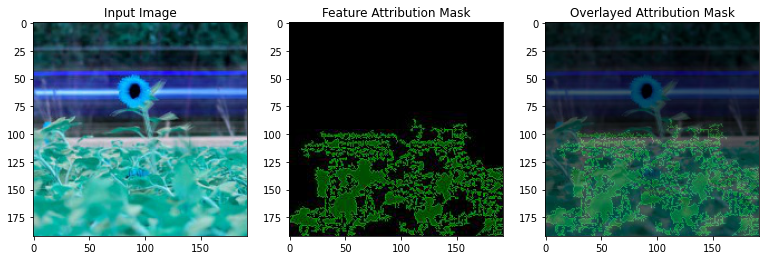

In [29]:
import io
from io import BytesIO

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

CLASSES = [
    "daisy",
    "dandelion",
    "roses",
    "sunflowers",
    "tulips",
]

for prediction in response.predictions:
    label_index = np.argmax(prediction)
    class_name = CLASSES[label_index]
    confidence_score = prediction[label_index]
    print(
        "Predicted class: "
        + class_name
        + "\n"
        + "Confidence score: "
        + str(confidence_score)
    )

    image = base64.b64decode(b64str)
    image = BytesIO(image)
    img = mpimg.imread(image, format="JPG")

for explanation in response.explanations:
    attributions = dict(explanation.attributions[0].feature_attributions)
    xai_label_index = explanation.attributions[0].output_index[0]
    xai_class_name = CLASSES[xai_label_index]
    xai_b64str = attributions["image"]["b64_jpeg"]
    xai_image = base64.b64decode(xai_b64str)
    xai_image = io.BytesIO(xai_image)
    xai_img = mpimg.imread(xai_image, format="JPG")

fig = plt.figure(figsize=(13, 18))
fig.add_subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(img)
fig.add_subplot(1, 3, 2)
plt.title("Feature Attribution Mask")
plt.imshow(xai_img)
fig.add_subplot(1, 3, 3)
plt.title("Overlayed Attribution Mask")
plt.imshow(img)
plt.imshow(xai_img, alpha=0.6)
plt.show()